# Garbage Classification - Standalone Prediction Notebook

Notebook này dùng để phân loại rác từ ảnh được import bằng URL hoặc upload từ máy tính.

**Lưu ý:**
- Notebook này được tối ưu cho Google Colab
- Model được load từ Google Drive: `/content/drive/MyDrive/NAM4/HMUD/garbage_classifier_model.pth`
- Cần mount Google Drive trước khi load model


In [1]:
# Install required packages (chạy lần đầu nếu cần)
%pip install torch torchvision pillow matplotlib requests -q


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("✓ Google Drive mounted successfully")


Mounted at /content/drive
✓ Google Drive mounted successfully


In [3]:
# Import libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import os

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


In [4]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ Using CPU (sẽ chậm hơn GPU)")


Using device: cuda
GPU: Tesla T4


In [5]:
# Define class names
class_names = [
    'battery',
    'biological',
    'cardboard',
    'clothes',
    'glass',
    'metal',
    'paper',
    'plastic',
    'shoes',
    'trash'
]

num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")


Number of classes: 10
Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [6]:
# Define image transforms (giống như validation/test trong training)
DATASET_MEAN = [0.5, 0.5, 0.5]
DATASET_STD = [0.5, 0.5, 0.5]

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize về 224x224
    transforms.ToTensor(),  # Chuyển sang tensor [0, 1]
    transforms.Normalize(mean=DATASET_MEAN, std=DATASET_STD)  # Normalize về [-1, 1]
])

print("✓ Transforms defined")


✓ Transforms defined


In [7]:
# Define Custom CNN Model Architecture (giống như trong training)
class GarbageClassifier(nn.Module):
    """
    Custom CNN architecture cho phân loại rác thải
    Architecture: 4 Conv Blocks + Global Average Pooling + 2 FC layers
    """
    def __init__(self, num_classes=10):
        super(GarbageClassifier, self).__init__()

        # Feature extractor - 4 Conv Blocks
        self.features = nn.Sequential(
            # Block 1: 224x224 → 112x112
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.1),

            # Block 2: 112x112 → 56x56
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),

            # Block 3: 56x56 → 28x28
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.3),

            # Block 4: 28x28 → 14x14
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.4),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling: 14x14 → 1x1
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print("✓ Model architecture defined")


✓ Model architecture defined


In [16]:
# Load Model from Checkpoint
print("=" * 70)
print("LOADING MODEL")
print("=" * 70)

# Đường dẫn đến model từ Google Drive
model_path = '/content/drive/MyDrive/NAM4/HMUD/garbage_classifier_model.pth'

# Function để load model
def load_checkpoint(path, device, num_classes):
    """Load model từ checkpoint"""
    print(f"Loading checkpoint from: {path}")
    checkpoint = torch.load(path, map_location=device)

    # Debug: Kiểm tra cấu trúc checkpoint
    print(f"Checkpoint type: {type(checkpoint)}")
    if isinstance(checkpoint, dict):
        print(f"Checkpoint keys: {list(checkpoint.keys())}")

    # Nếu checkpoint là full model
    if isinstance(checkpoint, nn.Module):
        print("Checkpoint is a full model object")
        model = checkpoint
        model.to(device)
        model.eval()
        return model

    # Nếu checkpoint là dict, tìm state_dict
    state = None
    if isinstance(checkpoint, dict):
        # Thử các key có thể có
        if 'model_state_dict' in checkpoint:
            state = checkpoint['model_state_dict']
            print("Found 'model_state_dict' in checkpoint")
        elif 'state_dict' in checkpoint:
            state = checkpoint['state_dict']
            print("Found 'state_dict' in checkpoint")
        else:
            # Nếu không có key nào, có thể toàn bộ dict là state_dict
            state = checkpoint
            print("Using entire checkpoint as state_dict")

    if state is None:
        raise ValueError("Could not find state_dict in checkpoint")

    # Detect số classes từ checkpoint
    final_key = None
    for k in state.keys():
        if 'classifier' in k and 'weight' in k:
            # Tìm layer cuối cùng trong classifier
            if 'classifier.6.weight' in k or 'classifier.5.weight' in k:
                final_key = k
                break
        elif k.endswith('fc.weight') or k.endswith('classifier.weight'):
            final_key = k
            break

    if final_key:
        detected_classes = state[final_key].shape[0]
        print(f"Detected {detected_classes} classes from checkpoint (key: {final_key})")
        if detected_classes != num_classes:
            print(f"⚠️ Warning: Detected {detected_classes} classes, but expected {num_classes}")
            # Sử dụng số classes từ checkpoint
            num_classes = detected_classes
    else:
        print("⚠️ Could not detect number of classes from checkpoint, using default")

    # Tạo model với architecture đã định nghĩa
    model = GarbageClassifier(num_classes=num_classes)

    # Load state dict - thử nhiều cách
    loaded = False

    # Cách 1: Load trực tiếp
    try:
        model.load_state_dict(state, strict=True)
        print("✓ Loaded state_dict successfully (strict=True)")
        loaded = True
    except Exception as e1:
        print(f"⚠️ Failed to load with strict=True: {e1}")

        # Cách 2: Remove 'module.' prefix (từ DataParallel)
        try:
            new_state = {}
            for k, v in state.items():
                new_key = k.replace('module.', '')
                new_state[new_key] = v
            model.load_state_dict(new_state, strict=True)
            print("✓ Loaded state_dict successfully after removing 'module.' prefix")
            loaded = True
        except Exception as e2:
            print(f"⚠️ Failed after removing 'module.' prefix: {e2}")

            # Cách 3: Load với strict=False
            try:
                model.load_state_dict(state, strict=False)
                print("✓ Loaded state_dict with strict=False (some layers may not match)")
                loaded = True
            except Exception as e3:
                print(f"⚠️ Failed with strict=False: {e3}")

                # Cách 4: Remove 'module.' và load với strict=False
                try:
                    new_state = {k.replace('module.', ''): v for k, v in state.items()}
                    model.load_state_dict(new_state, strict=False)
                    print("✓ Loaded state_dict after removing 'module.' prefix with strict=False")
                    loaded = True
                except Exception as e4:
                    print(f"❌ All loading methods failed. Last error: {e4}")
                    raise

    if not loaded:
        raise RuntimeError("Failed to load model state_dict")

    model.to(device)
    model.eval()

    # Kiểm tra một số weights để đảm bảo model đã được load
    with torch.no_grad():
        sample_input = torch.randn(1, 3, 224, 224).to(device)
        output = model(sample_input)
        print(f"✓ Model test forward pass successful. Output shape: {output.shape}")
        print(f"  Output range: [{output.min().item():.2f}, {output.max().item():.2f}]")

    return model

# Load model
if os.path.exists(model_path):
    print(f"Loading model from: {model_path}")
    model = load_checkpoint(model_path, device, num_classes)
    print("✓ Model loaded successfully!")
    print(f"Model on device: {next(model.parameters()).device}")

    # Test forward pass
    print("\nTesting forward pass...")
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    with torch.no_grad():
        output = model(dummy_input)
    print(f"  Input shape: {dummy_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  ✓ Forward pass successful!")

else:
    raise FileNotFoundError(
        f"Model file not found at: {model_path}\n"
        f"Please ensure the model file exists or update the model_path variable."
    )

print("=" * 70)


LOADING MODEL
Loading model from: /content/drive/MyDrive/NAM4/HMUD/garbage_classifier_model.pth
Loading checkpoint from: /content/drive/MyDrive/NAM4/HMUD/garbage_classifier_model.pth
Checkpoint type: <class 'dict'>
Checkpoint keys: ['epoch', 'model_state_dict', 'optimizer_state_dict', 'val_acc', 'val_loss', 'num_classes', 'class_names', 'history']
Found 'model_state_dict' in checkpoint
Detected 10 classes from checkpoint (key: classifier.6.weight)
✓ Loaded state_dict successfully (strict=True)
✓ Model test forward pass successful. Output shape: torch.Size([1, 10])
  Output range: [-6.06, 5.20]
✓ Model loaded successfully!
Model on device: cuda:0

Testing forward pass...
  Input shape: torch.Size([1, 3, 224, 224])
  Output shape: torch.Size([1, 10])
  ✓ Forward pass successful!


## Predict từ Image URL

Nhập URL ảnh vào biến `image_url` bên dưới và chạy cell này.


PREDICTING FROM USER-PROVIDED IMAGE URL
✓ Image downloaded successfully.


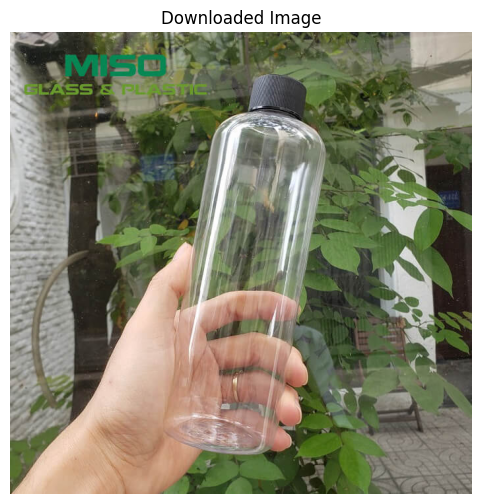

In [21]:
# Download Image from URL
print("=" * 70)
print("PREDICTING FROM USER-PROVIDED IMAGE URL")
print("=" * 70)

# Nhập URL ảnh ở đây
image_url = "https://thuytinhmiso.com/wp-content/uploads/2017/03/Chai-nhua-PET-cao-500ml-cao-cap.jpg"

if image_url == "https://example.com/your_image.jpg" or not image_url:
    print("Vui lòng nhập URL ảnh để dự đoán.")
    img = None
else:
    print(f"Downloading image from: {image_url}")
    try:
        response = requests.get(image_url, timeout=10)
        response.raise_for_status()  # Raise an exception for HTTP errors
        img = Image.open(BytesIO(response.content))

        # Convert to RGB nếu cần
        if img.mode != 'RGB':
            img = img.convert('RGB')

        print("✓ Image downloaded successfully.")

        # Hiển thị ảnh vừa tải về
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title("Downloaded Image")
        plt.axis('off')
        plt.show()

    except requests.exceptions.RequestException as e:
        print(f"❌ Error downloading image: {e}")
        img = None
    except Exception as e:
        print(f"❌ Error processing image from URL: {e}")
        img = None

print("=" * 70)


In [22]:
# Predict Image
if 'img' in locals() and img is not None:
    print("=" * 70)
    print("PREPROCESSING AND PREDICTING")
    print("=" * 70)

    # Đảm bảo model ở chế độ evaluation
    model.eval()

    # Áp dụng transform
    input_tensor = val_test_transform(img).unsqueeze(0)  # Thêm batch dimension
    input_tensor = input_tensor.to(device)

    # Kiểm tra input tensor
    print(f"Input tensor shape: {input_tensor.shape}")
    print(f"Input tensor range: [{input_tensor.min().item():.3f}, {input_tensor.max().item():.3f}]")

    # Dự đoán
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Kiểm tra output
    print(f"Raw output range: [{outputs.min().item():.2f}, {outputs.max().item():.2f}]")
    print(f"Probabilities sum: {probabilities.sum().item():.4f}")

    # Lấy kết quả dự đoán
    predicted_prob, predicted_idx = torch.max(probabilities, dim=1)
    predicted_class = class_names[predicted_idx.item()]

    print(f"\n✓ Prediction complete!")
    print(f"  Predicted Class: {predicted_class}")
    print(f"  Confidence: {predicted_prob.item()*100:.2f}%")

    # Hiển thị top-5 predictions
    top_p, top_class_idx = probabilities.topk(5, dim=1)
    top_p = top_p.squeeze().cpu().numpy()
    top_class_idx = top_class_idx.squeeze().cpu().numpy()

    print("\nTop 5 Predictions:")
    for i in range(len(top_p)):
        class_name = class_names[top_class_idx[i]]
        print(f"  {i+1}. {class_name}: {top_p[i]*100:.2f}%")

    # Cảnh báo nếu confidence quá thấp
    if predicted_prob.item() < 0.3:
        print(f"\n⚠️ Warning: Low confidence prediction ({predicted_prob.item()*100:.2f}%)")
        print("   This might indicate:")
        print("   - Model weights may not be loaded correctly")
        print("   - Image preprocessing may be incorrect")
        print("   - Model may need retraining")

    print("=" * 70)
else:
    print("Không có ảnh để xử lý. Vui lòng kiểm tra URL ảnh hoặc chạy cell download ảnh trước.")


PREPROCESSING AND PREDICTING
Input tensor shape: torch.Size([1, 3, 224, 224])
Input tensor range: [-0.961, 0.992]
Raw output range: [-3.34, 0.70]
Probabilities sum: 1.0000

✓ Prediction complete!
  Predicted Class: plastic
  Confidence: 31.21%

Top 5 Predictions:
  1. plastic: 31.21%
  2. clothes: 20.92%
  3. glass: 14.16%
  4. paper: 12.23%
  5. biological: 7.68%


## Predict từ Uploaded Image File

Upload ảnh từ máy tính của bạn bằng cách chạy cell bên dưới.


UPLOAD IMAGE FROM YOUR COMPUTER
Click 'Choose Files' button below to upload an image...


Saving de-thua-thuc-an-lang-phi-tao-nghiep-gi-2-0700-0718.webp to de-thua-thuc-an-lang-phi-tao-nghiep-gi-2-0700-0718.webp

✓ File uploaded: de-thua-thuc-an-lang-phi-tao-nghiep-gi-2-0700-0718.webp
✓ Image loaded successfully.


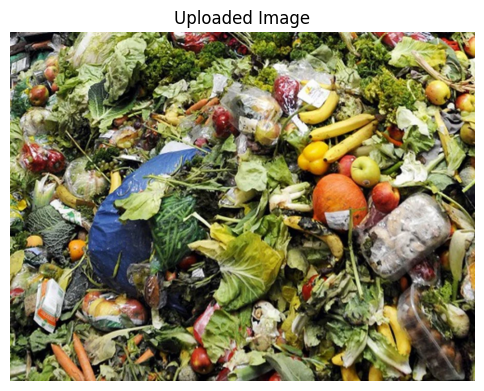


PREPROCESSING AND PREDICTING
Input tensor shape: torch.Size([1, 3, 224, 224])
Input tensor range: [-1.000, 1.000]
Raw output range: [-5.96, 4.20]
Probabilities sum: 1.0000

✓ Prediction complete!
  Predicted Class: biological
  Confidence: 98.91%

Top 5 Predictions:
  1. biological: 98.91%
  2. trash: 0.58%
  3. shoes: 0.22%
  4. paper: 0.14%
  5. battery: 0.06%


In [29]:
# Upload Image from Local File (Google Colab)
from google.colab import files
import io

print("=" * 70)
print("UPLOAD IMAGE FROM YOUR COMPUTER")
print("=" * 70)
print("Click 'Choose Files' button below to upload an image...")

# Upload file
uploaded = files.upload()

if uploaded:
    # Lấy tên file đầu tiên
    filename = list(uploaded.keys())[0]
    print(f"\n✓ File uploaded: {filename}")

    # Đọc ảnh từ uploaded file
    img = Image.open(io.BytesIO(uploaded[filename]))

    # Convert to RGB nếu cần
    if img.mode != 'RGB':
        img = img.convert('RGB')

    print("✓ Image loaded successfully.")

    # Hiển thị ảnh
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()

    # Chạy prediction
    print("\n" + "=" * 70)
    print("PREPROCESSING AND PREDICTING")
    print("=" * 70)

    # Đảm bảo model ở chế độ evaluation
    model.eval()

    # Áp dụng transform
    input_tensor = val_test_transform(img).unsqueeze(0)
    input_tensor = input_tensor.to(device)

    # Kiểm tra input tensor
    print(f"Input tensor shape: {input_tensor.shape}")
    print(f"Input tensor range: [{input_tensor.min().item():.3f}, {input_tensor.max().item():.3f}]")

    # Dự đoán
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Kiểm tra output
    print(f"Raw output range: [{outputs.min().item():.2f}, {outputs.max().item():.2f}]")
    print(f"Probabilities sum: {probabilities.sum().item():.4f}")

    # Lấy kết quả dự đoán
    predicted_prob, predicted_idx = torch.max(probabilities, dim=1)
    predicted_class = class_names[predicted_idx.item()]

    print(f"\n✓ Prediction complete!")
    print(f"  Predicted Class: {predicted_class}")
    print(f"  Confidence: {predicted_prob.item()*100:.2f}%")

    # Hiển thị top-5 predictions
    top_p, top_class_idx = probabilities.topk(5, dim=1)
    top_p = top_p.squeeze().cpu().numpy()
    top_class_idx = top_class_idx.squeeze().cpu().numpy()

    print("\nTop 5 Predictions:")
    for i in range(len(top_p)):
        class_name = class_names[top_class_idx[i]]
        print(f"  {i+1}. {class_name}: {top_p[i]*100:.2f}%")

    # Cảnh báo nếu confidence quá thấp
    if predicted_prob.item() < 0.3:
        print(f"\n⚠️ Warning: Low confidence prediction ({predicted_prob.item()*100:.2f}%)")
        print("   This might indicate:")
        print("   - Model weights may not be loaded correctly")
        print("   - Image preprocessing may be incorrect")
        print("   - Model may need retraining")

    print("=" * 70)

else:
    print("⚠️ No file uploaded. Please upload an image file.")
